In [ ]:
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from models.model_clam import CLAM_MB, CLAM_SB  
import torch.nn as nn
import csv
import re
import pickle
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import os

import openslide
from openslide import OpenSlide

Image.MAX_IMAGE_PIXELS = None 
from PIL import Image, ImageOps, ImageDraw, ImageFont

from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
from matplotlib.cm import inferno

# This part finds the test sets for each fold and infer the embedings to the model. This extracts the attention score and coordinates for each embeding will also be tracked. Then the attention scores for all folds would be aggregated and grouped according to the staining and and visulized.

This part assumes the segmentation and aggregation was done and also there are trained models already with splits and everything

In [40]:
# loading the model
def load_model(model_path, model_type='CLAM_SB'):
    model = CLAM_SB(gate=True, size_arg="micro_tiny", dropout=True, k_sample=700, n_classes=2, instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Perform inference and extract attention scores
def infer_and_extract_attention(model, features):
    with torch.inference_mode():
        output = model(features)
        logits, Y_prob, Y_hat, attention_scores, _ = output
        attention_scores = attention_scores.view(-1).cpu().numpy() 
    return logits, Y_prob, Y_hat, attention_scores

# group the coordinates and their scores for the tma
def classify_tma_by_staining(tma_coords, tma_scores):
    stainings = ["CD163", "CD3", "CD56", "CD68", "CD8", "HE", "MHC1", "PDL1"]
    total_width = 36000  
    staining_intervals = total_width / 8
    staining_scores_coords_dict = {stain: [] for stain in stainings}

    for coord, score in zip(tma_coords, tma_scores):
        index = int(coord[0] // staining_intervals)
        staining_scores_coords_dict[stainings[index]].append((score, coord))
    return staining_scores_coords_dict

# grouping based on the staining and modality 
def calculate_wsi_tma(h5_file_path, attn_scores, coords):
    with h5py.File(h5_file_path, 'r') as file:
        features = file['features']
        split_index = features.shape[0]  

    tma_scores = attn_scores[:split_index]
    tma_coords = coords[:split_index]

    wsi_scores = attn_scores[split_index:]
    wsi_coords = coords[split_index:]
    
    staining_scores_coords_dict = classify_tma_by_staining(tma_coords, tma_scores)
    staining_scores_coords_dict['WSI'] = list(zip(wsi_scores, wsi_coords))

    return staining_scores_coords_dict

# score calculater
def calculate_attention_scores_dict(attn_scores, split_index, tma_stainings):
    scores_dict = {}

    # Calculate scores for each TMA staining and WSI
    for staining, indices in tma_stainings.items():
        scores = [attn_scores[j] for j in indices]
        scores_dict[staining] = scores

    # Calculate scores for WSI
    wsi_scores = attn_scores[split_index:]
    scores_dict['WSI'] = wsi_scores
    return scores_dict

# the 3d distribution
def plot_attention_scores_histogram_3d(scores_dict, prob, label, id,task="none"):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'grey']
    
    extracted_scores = {staining: [score for score, _ in scores_list] for staining, scores_list in scores_dict.items()}
    
    # Flatten all scores to determine the histogram bins
    all_scores = [score for sublist in extracted_scores.values() for score in sublist]
    bins = np.linspace(min(all_scores), max(all_scores), 50)
    bin_width = bins[1] - bins[0]
    bar_width = bin_width * 0.9  # for the spacing

    space_between_groups = 25
    zs = np.arange(len(extracted_scores)) * space_between_groups + (space_between_groups / 2)

    mean_scores_dict = {}

    # histograms for each group
    for i, (staining, scores) in enumerate(extracted_scores.items()):
        if len(scores) > 0:
            hist, _ = np.histogram(scores, bins=bins)
            xs = (bins[:-1] + bins[1:]) / 2
            mean_scores = np.mean(scores)
            max_scores = np.max(scores)
        else:
            hist = np.zeros_like(bins[:-1])
            xs = (bins[:-1] + bins[1:]) / 2
            mean_scores = 0
            max_scores = 0

        mean_scores_dict[staining] = mean_scores
        ax.bar(xs, hist, zs=zs[i], zdir='y', width=bar_width, color=colors[i % len(colors)], alpha=0.7, label=f'{staining} (Mean: {mean_scores:.2f}), (Max: {max_scores:.2f})')

    ax.set_xlabel('Attention Score')
    ax.set_ylabel('Group')
    ax.set_zlabel('Frequency')
    ax.tick_params(axis='z', which='major', labelsize=8)
    
    ax.set_ylim(20, zs[-1] + 20) 
    
    ax.set_yticks(zs + 25)
    ax.set_yticklabels(list(extracted_scores.keys()))
    
    plt.title('Attention Scores by Group')
    plt.legend(loc='upper left')
    plt.savefig(f"/data/ve59kedo/thesis/PLOTS/3d_{task}.png")


# The 2d distribution
def plot_attention_scores_histogram_2d(scores_dict, prob, label, id, auc):
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'grey']

    extracted_scores = {staining: [score for score, _ in scores_list] for staining, scores_list in scores_dict.items()}

    mean_scores_dict = {}

    # Plot histograms for each group
    for i, (staining, scores) in enumerate(extracted_scores.items()):
        scores = np.array(scores)  
        
        if len(scores) > 0:
            mean_scores = np.mean(scores)
            positive_scores = scores[scores > 0]
            
            if len(positive_scores) > 0:
                mean_positive_scores = np.mean(positive_scores)
            else:
                mean_positive_scores = 0
                
            sns.kdeplot(scores, color=colors[i % len(colors)], label=f'{staining} (Mean: {mean_scores:.2f} P_Mean: {mean_positive_scores:.2f})', fill=True, ax=ax)
        else:
            mean_scores = 0

        mean_scores_dict[staining] = mean_scores

    plt.figtext(0.02, 0.98, f'AUC: {auc:.2f}', fontsize=12, va="top", ha="left")

    ax.set_xlabel('Attention Score')
    ax.set_ylabel('Frequency')
    plt.title(f'Attention Scores Distribution (Fold)')
    plt.legend(loc='upper left')
    plt.savefig(f"/data/ve59kedo/thesis/2d.png")


# finds the test data patient ids
def extract_test_set_ids(csv_file_path):
    test_ids = []
    with open(csv_file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            test_ids.extend(re.findall(r'\d{3}', row['test']))
    return test_ids


# concatinatino of two dicts
def accumulate_scores(aggregate_scores_dict, new_scores_dict):
    stainings = ["CD163", "CD3", "CD56", "CD68", "CD8", "HE", "MHC1", "PDL1", "WSI"]
    for staining in stainings:
        if staining not in aggregate_scores_dict:
            aggregate_scores_dict[staining] = []

    for key, tuples in new_scores_dict.items():
        if key in aggregate_scores_dict:
            aggregate_scores_dict[key].extend(tuples)
        else:
            print(f"Key: '{key}' was empty, skipped.")

    return aggregate_scores_dict
    
# Returns the probability and label for a given id from a .pkl file.
def get_prob_and_label(id, filepath):

    try:
        id = f"AG2_{id}"
        with open(filepath, 'rb') as file:
            data = pickle.load(file)

            if id in data:
                prob = data[id]['prob']
                label = data[id]['label']
                return prob, label
            else:
                return None, None  # I
    except FileNotFoundError:
        print("The file was not found.")
        return None, None
    except Exception as errorr:
        print(f" error: {errorr}")
        return None, None

        

# plots the attened patches by fiding the from the data dir

def plot_tiles(data_dict, k, id, fold,prob,label,tile_size=(256, 256)):
    fig, axes = plt.subplots(nrows=len(data_dict), ncols=k, figsize=(k * 1, len(data_dict)* 1))
    
    for i, (staining, values) in enumerate(data_dict.items()):
        sorted_values = sorted(values, key=lambda x: x[0], reverse=True)
        
        if staining == "WSI":
            image_path = os.path.join('/data_slow/ve59kedo/wsi', f"PrimaryTumor_HE_{id}.svs")
            image = openslide.OpenSlide(image_path)
        else:
            image_path = os.path.join('/data_slow2/ve59kedo/TMA/TMA_ordered', f"DSTMA_patient_{id}.tiff")
            image = Image.open(image_path)
        
        for j in range(k):
            score, coords = sorted_values[j]
            x, y = coords
            if staining == "WSI":

                tile = image.read_region((x, y), 0, tile_size).convert('RGB')
            else:
                tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))
            
            # Plot the tile
            ax = axes[i][j] if len(data_dict) > 1 else axes[j]
            ax.imshow(tile)
            ax.axis('off')
            ax.set_title(f"{staining} {score:.2f}",fontsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0.25)
    plt.suptitle(f'Top{k} Most Attended, {id}', fontsize=12)
    plt.savefig(f"/data/ve59kedo/thesis/PLOTS/most_tiles_{id}_{fold}_{prob}_{label}_rec.png",dpi=300)


# AUC for the fold
def get_test_auc_for_fold(summary_path, fold):
    with open(summary_path, 'r') as file:
        csv_reader = csv.reader(file)
        
        next(csv_reader)
        
        for row in csv_reader:
            if int(row[1]) == fold:
                return float(row[2])
    
    return None


if __name__ == '__main__':

    stainings = ["CD163", "CD3", "CD56", "CD68", "CD8", "HE", "MHC1", "PDL1", "WSI"]

    aggregate_scores_dict_all_rec = {key: [] for key in stainings}

    for fold in range(10):  
        csv_file_path = f'/data/ve59kedo/thesis/results_2/UNI_rec_AG_2class/exp_th3_sampled_2_s1/splits_{fold}.csv'
        test_ids = extract_test_set_ids(csv_file_path)

        aggregate_scores_dict = {key: [] for key in stainings}

        counter = 0
        summary_path = f'/data/ve59kedo/thesis/results_2/UNI_rec_AG_2class/exp_th3_sampled_2_s1/summary.csv'
        for id in test_ids:
            print(f"Fold: {fold}, ID: {id}")
            model_path = f'/data/ve59kedo/thesis/results_2/UNI_rec_AG_2class/exp_th3_sampled_2_s1/s_{fold}_checkpoint.pt'
            h5_ag = f'/data_slow2/ve59kedo/UNI_AG2/h5_files/AG2_{id}.h5'
            h5_tma = f'/data_slow2/ve59kedo/UNI_DSTMA_feat2_256/h5_files/DSTMA_{id}.h5'
            filepath = f'/data/ve59kedo/thesis/results_2/UNI_rec_AG_2class/exp_th3_sampled_2_s1/split_{fold}_results.pkl'

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # Load the model
            model = load_model(model_path).to(device)

            # Load features and coordinates from the .h5 file
            with h5py.File(h5_ag, 'r') as file:
                features = torch.tensor(file['features'][:]).to(device)
                coords = file['coords'][:]

            # Perform inference
            logits, probabilities, predictions, attn_scores = infer_and_extract_attention(model, features)

            # Calculate atten scores and get split index
            all_scores_dict = calculate_wsi_tma(h5_tma, attn_scores, coords)

            prob, label = get_prob_and_label(id, filepath)


            counter += 1
            # if counter == 100:  stopping condition
            #     break

            # Accumulate attention scores for each staining
            aggregate_scores_dict = accumulate_scores(aggregate_scores_dict, all_scores_dict)

        # Plot the aggregate attention scores histogram for each fold
        auc = get_test_auc_for_fold(summary_path,fold)

        aggregate_scores_dict_all_rec = accumulate_scores(aggregate_scores_dict_all_rec, aggregate_scores_dict)


        
    

Fold: 0, ID: 004
Fold: 0, ID: 040
Fold: 0, ID: 041
Fold: 0, ID: 053
Fold: 0, ID: 086
Fold: 0, ID: 122
Fold: 0, ID: 146
Fold: 0, ID: 205
Fold: 0, ID: 209
Fold: 0, ID: 221
Fold: 0, ID: 236
Fold: 0, ID: 252
Fold: 0, ID: 261
Fold: 0, ID: 269
Fold: 0, ID: 276
Fold: 0, ID: 279
Fold: 0, ID: 283
Fold: 0, ID: 285
Fold: 0, ID: 298
Fold: 0, ID: 301
Fold: 0, ID: 325
Fold: 0, ID: 346
Fold: 0, ID: 385
Fold: 0, ID: 391
Fold: 0, ID: 392
Fold: 0, ID: 393
Fold: 0, ID: 409
Fold: 0, ID: 453
Fold: 0, ID: 509
Fold: 0, ID: 519
Fold: 0, ID: 521
Fold: 0, ID: 534
Fold: 0, ID: 545
Fold: 0, ID: 574
Fold: 0, ID: 588
Fold: 0, ID: 594
Fold: 0, ID: 600
Fold: 0, ID: 602
Fold: 0, ID: 606
Fold: 0, ID: 613
Fold: 0, ID: 616
Fold: 0, ID: 619
Fold: 0, ID: 632
Fold: 0, ID: 635
Fold: 0, ID: 650
Fold: 0, ID: 680
Fold: 0, ID: 684
Fold: 0, ID: 716
Fold: 1, ID: 011
Fold: 1, ID: 018
Fold: 1, ID: 021
Fold: 1, ID: 033
Fold: 1, ID: 047
Fold: 1, ID: 053
Fold: 1, ID: 101
Fold: 1, ID: 108
Fold: 1, ID: 124
Fold: 1, ID: 141
Fold: 1, ID: 1

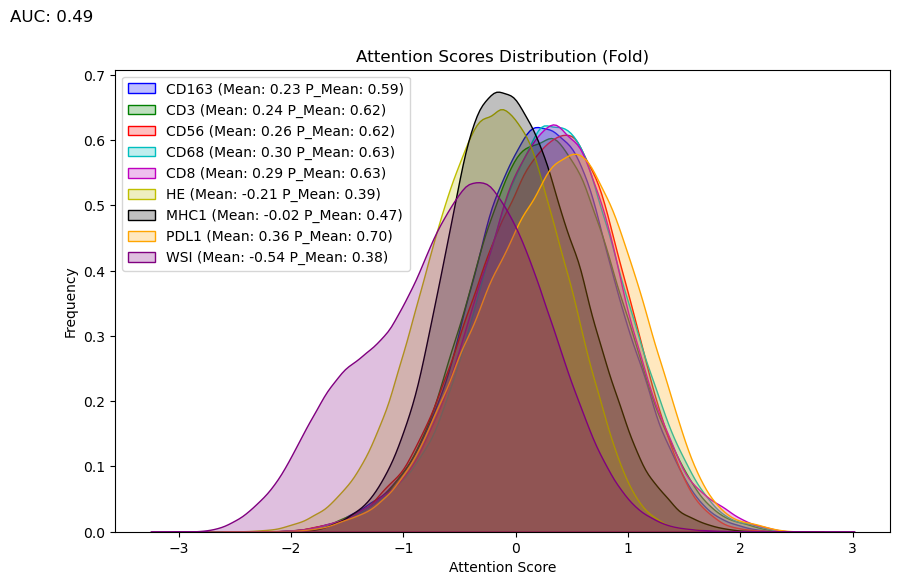

In [41]:
plot_attention_scores_histogram_2d(aggregate_scores_dict_all_rec, prob, label, auc=auc,id=f"Attention Distribution for Fold all folds")



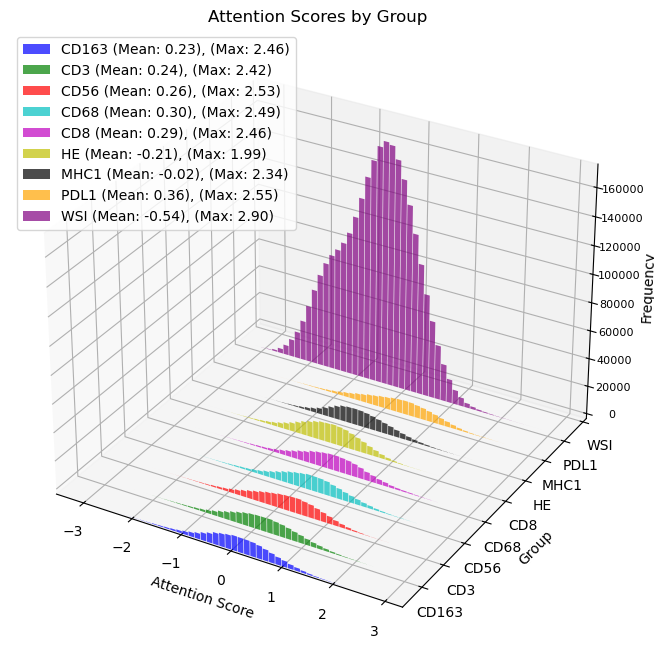

In [42]:
plot_attention_scores_histogram_3d(aggregate_scores_dict_all_rec, prob, label,task="REC",id=f"Reccurence Attention Distribution")


# Same is above but for survival status

In [43]:

def load_model(model_path, model_type='CLAM_SB'):
    model = CLAM_SB(gate=True, size_arg="tiny", dropout=True, k_sample=700, n_classes=2, instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

if __name__ == '__main__':
    aggregate_scores_dict_all_surv = {key: [] for key in stainings}

    for fold in range(10):  
        csv_file_path = f'/data/ve59kedo/thesis/results_2/UNI_surv_AG_2class/exp_th4_sampled_1_s1/splits_{fold}.csv'
        test_ids = extract_test_set_ids(csv_file_path)

        stainings = ["CD163", "CD3", "CD56", "CD68", "CD8", "HE", "MHC1", "PDL1", "WSI"]
        aggregate_scores_dict = {key: [] for key in stainings}

        counter = 0
        summary_path = f'/data/ve59kedo/thesis/results_2/UNI_surv_AG_2class/exp_th4_sampled_1_s1/summary.csv'
        for id in test_ids:
            print(f"Fold: {fold}, ID: {id}")
            model_path = f'/data/ve59kedo/thesis/results_2/UNI_surv_AG_2class/exp_th4_sampled_1_s1/s_{fold}_checkpoint.pt'
            h5_ag = f'/data_slow2/ve59kedo/UNI_AG2/h5_files/AG2_{id}.h5'
            h5_tma = f'/data_slow2/ve59kedo/UNI_DSTMA_feat2_256/h5_files/DSTMA_{id}.h5'
            filepath = f'/data/ve59kedo/thesis/results_2/UNI_surv_AG_2class/exp_th4_sampled_1_s1/split_{fold}_results.pkl'

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            model = load_model(model_path).to(device)

            with h5py.File(h5_ag, 'r') as file:
                features = torch.tensor(file['features'][:]).to(device)
                coords = file['coords'][:]

            logits, probabilities, predictions, attn_scores = infer_and_extract_attention(model, features)

            all_scores_dict = calculate_wsi_tma(h5_tma, attn_scores, coords)

            prob, label = get_prob_and_label(id, filepath)


            counter += 1
            if counter == 100:  
                break

            aggregate_scores_dict = accumulate_scores(aggregate_scores_dict, all_scores_dict)

        auc = get_test_auc_for_fold(summary_path,fold)
        aggregate_scores_dict_all_surv = accumulate_scores(aggregate_scores_dict_all_surv, aggregate_scores_dict)

        
    

Fold: 0, ID: 002
Fold: 0, ID: 038
Fold: 0, ID: 053
Fold: 0, ID: 056
Fold: 0, ID: 093
Fold: 0, ID: 130
Fold: 0, ID: 165
Fold: 0, ID: 222
Fold: 0, ID: 231
Fold: 0, ID: 251
Fold: 0, ID: 256
Fold: 0, ID: 261
Fold: 0, ID: 263
Fold: 0, ID: 311
Fold: 0, ID: 321
Fold: 0, ID: 343
Fold: 0, ID: 347
Fold: 0, ID: 356
Fold: 0, ID: 364
Fold: 0, ID: 391
Fold: 0, ID: 403
Fold: 0, ID: 421
Fold: 0, ID: 429
Fold: 0, ID: 434
Fold: 0, ID: 467
Fold: 0, ID: 528
Fold: 0, ID: 543
Fold: 0, ID: 577
Fold: 0, ID: 600
Fold: 0, ID: 625
Fold: 0, ID: 627
Fold: 0, ID: 652
Fold: 0, ID: 653
Fold: 0, ID: 672
Fold: 0, ID: 684
Fold: 0, ID: 701
Fold: 0, ID: 758
Fold: 1, ID: 040
Fold: 1, ID: 050
Fold: 1, ID: 051
Fold: 1, ID: 053
Fold: 1, ID: 071
Fold: 1, ID: 095
Fold: 1, ID: 103
Fold: 1, ID: 140
Fold: 1, ID: 142
Fold: 1, ID: 176
Fold: 1, ID: 200
Fold: 1, ID: 205
Fold: 1, ID: 229
Fold: 1, ID: 234
Fold: 1, ID: 254
Fold: 1, ID: 258
Fold: 1, ID: 262
Fold: 1, ID: 263
Fold: 1, ID: 306
Fold: 1, ID: 325
Fold: 1, ID: 367
Fold: 1, ID: 3

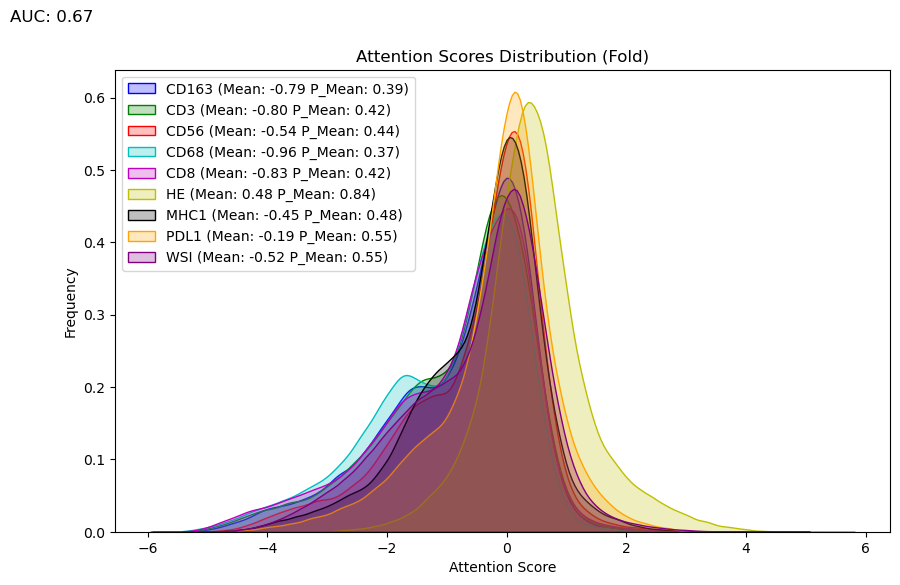

In [44]:
plot_attention_scores_histogram_2d(aggregate_scores_dict_all_surv, prob, label, auc=auc,id=f"Attention Distribution for Fold all folds")


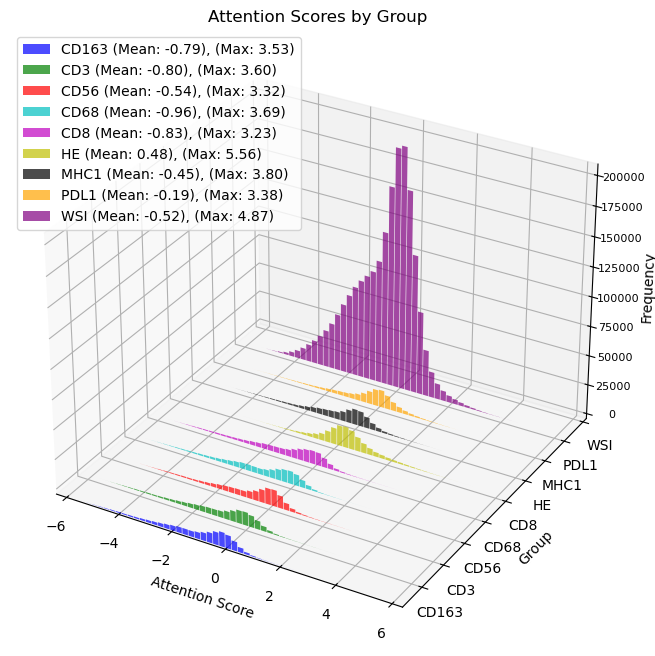

In [45]:
plot_attention_scores_histogram_3d(aggregate_scores_dict_all_surv, prob, label,task="SURV",id=f"Reccurence Attention Distribution")


# plotting attention map for WSI

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

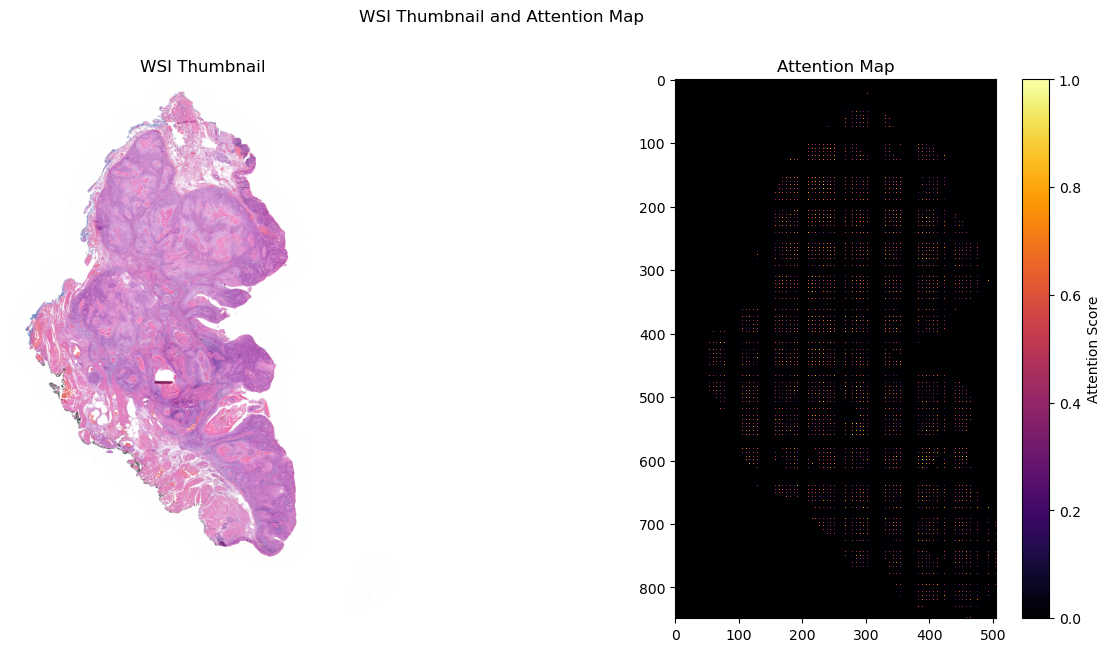

In [6]:

def plot_attention_map(attention_dict, wsi_path, id):
    tiles = attention_dict["WSI"]
    coordinates = [tile[1] for tile in tiles]
    scores = [tile[0] for tile in tiles]

    min_score = min(scores)
    max_score = max(scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]

    max_x = max(coord[0] for coord in coordinates)
    max_y = max(coord[1] for coord in coordinates)

    tile_size = 256

    canvas_width = (max_x // tile_size) + 1
    canvas_height = (max_y // tile_size) + 1

    canvas = np.zeros((canvas_height, canvas_width))

    for coord, norm_score in zip(coordinates, normalized_scores):
        x = coord[0] // tile_size
        y = coord[1] // tile_size
        canvas[y, x] = norm_score

    downsample_factor = 1 
    downsampled_canvas = canvas[::downsample_factor, ::downsample_factor]

    wsi_path = wsi_path + f"PrimaryTumor_HE_{id}.svs"
    wsi = OpenSlide(wsi_path)
    thumbnail = wsi.get_thumbnail((wsi.dimensions[0] // 100, wsi.dimensions[1] // 100))

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    axes[0].imshow(thumbnail)
    axes[0].set_title('WSI Thumbnail')
    axes[0].axis('off')
    
    im = axes[1].imshow(downsampled_canvas, cmap='inferno', interpolation='nearest')
    axes[1].set_title('Attention Map')
    plt.colorbar(im, ax=axes[1], label='Attention Score')

    plt.suptitle('WSI Thumbnail and Attention Map')
    plt.show()


wsi_path = '/data_slow/ve59kedo/wsi/'
plot_attention_map(all_scores_dict,wsi_path, id=id)


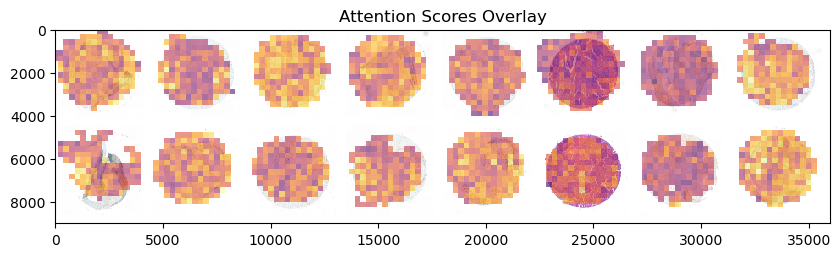

In [10]:


def plot_attention_map_TMA(tiff_file, attention_scores, alpha=0.6):
    img = Image.open(tiff_file)
    img_array = np.array(img)

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(img_array, cmap='gray')

    cmap = inferno
    norm = Normalize(vmin=min(score for scores in attention_scores.values() for score, _ in scores),
                     vmax=max(score for scores in attention_scores.values() for score, _ in scores))

    # Iterate over staining and with coordinates
    for staining, scores in attention_scores.items():
        if staining != 'WSI':
            coordinates = [coord for _, coord in scores]
            scores = [score for score, _ in scores]

            for (x, y), score in zip(coordinates, scores):
                x0 = x - 128  
                y0 = y - 128

                patch = Rectangle((x0, y0), 256, 256, edgecolor='none', facecolor=cmap(norm(score)), alpha=alpha) # makes a rectangle with a specific colors according to the attention score
                ax.add_patch(patch)

    ax.set_title('Attention Scores Overlay')
    plt.show()


# Example usage
plot_attention_map_TMA("/data_slow2/ve59kedo/TMA/TMA_ordered/DSTMA_patient_500.tiff", all_scores_dict)
